---
---

## Sentiment Analysis and Sentiment Modeling for Amazon Reviews


### İş Problemi

#### Amazon üzerinden satışlarını gerçekleştiren ev tekstili ve günlük giyim odaklı üretimler yapan Kozmos, ürünlerine gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlarını artırmayı hedeflemektedir. Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlenecek ve etiketlenen veri ile sınıflandırma modeli oluşturulacaktır.

---

### Veri Seti Hikayesi

#### Veri seti belirli bir ürün grubuna ait yapılan yorumları, yorum başlığını, yıldız sayısını ve yapılan yorumu kaç kişinin faydalı bulduğunu belirten değişkenlerden oluşmaktadır.

- Star : Ürüne verilen yıldız sayısı
- HelpFul : Yorumu faydalı bulan kişi sayısı
- Title : Yorum içeriğine verilen başlık, kısa yorum
- Review : Ürüne yapılan yorum

---

---


## İmport İşlemleri


In [ ]:
%pip install scikit-learn
%pip install textblob
%pip install nltk
%pip install wordcloud

In [116]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# Proje Görevleri


---
### Görev 1: Text Preprocessing



#### Adım 1: amazon.xlsx verisini okutunuz.


In [ ]:
%pip install openpyxl
import openpyxl

df = pd.read_excel("amazon.xlsx", engine='openpyxl')

In [80]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


#### Tüm harfleri küçük harfe çeviriniz.


In [81]:
df["Review"] = df["Review"].str.lower()

In [82]:
df["Review"].head()

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
Name: Review, dtype: object

#### Noktalama işaretlerini çıkarınız.


In [83]:
df["Review"] = df["Review"].str.replace(r"[^\w\s]", "", regex=True)

In [84]:
df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

#### Yorumlarda bulunan sayısal ifadeleri çıkarınız.


In [85]:
df["Review"] = df["Review"].str.replace(r"\d", "", regex=True)

#### Bilgi içermeyen kelimeleri (stopwords) veriden çıkarınız.


In [ ]:
import nltk

nltk.download("stopwords")

In [88]:
sw = stopwords.words("english")

In [90]:
df["Review"] = df["Review"].apply(
    lambda x: " ".join([x for x in str(x).split() if x not in sw])
)

In [91]:
df["Review"]

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme studioliv...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

#### 1000'den az geçen kelimeleri veriden çıkarınız.


In [95]:
tasinacak = pd.Series(" ".join(df["Review"]).split()).value_counts()[:-1000]


df["Review"] = df["Review"].apply(lambda x: " ".join([x for x in str(x).split() if x in tasinacak]))

### Lemmatization işlemini uygulayınız.


In [ ]:
nltk.download("wordnet")

In [97]:
df["Review"] = df["Review"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [98]:
df["Review"]

0                                                   happy
1          good quality material however panel mismatched
2       product fun bedroom windowsbr imagery bit stre...
3                                 lo que e que un poco ma
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                                color way panel match
5608    great studio complement entire theme area phot...
5609                         brought beauty kid room love
5610        cute curtain son room thick enough keep light
Name: Review, Length: 5611, dtype: object

---
### Görev 2: Text Visualization


#### "Review" değişkeninin içerdiği kelimelerin frekanslarını hesaplayınız, tf olarak kaydediniz.


In [99]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

#### tf dataframe'inin sütunlarını yeniden adlandırınız: "words", "tf" şeklinde

In [100]:
tf.columns = ["words", "tf"]

In [101]:
tf.head().sort_values(by="tf", ascending=False)

,words,tf
2,quality,889.00
3,material,565.00
1,good,536.00
0,happy,196.00
4,however,78.00


#### "tf" değişkeninin değeri 500'den çok olanlara göre filtreleme işlemi yaparak barplot ile görselleştirme işlemini tamamlayınız.

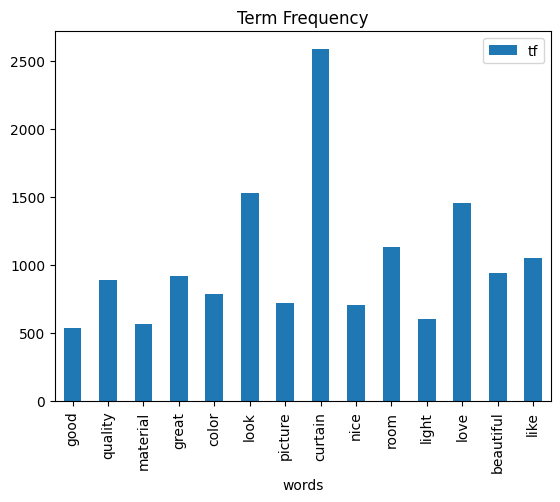

In [102]:
tf[tf["tf"]> 500].plot.bar(x="words", y="tf")
plt.title("Term Frequency")
plt.show()

#### "Review" değişkeninin içerdiği tüm kelimeleri "text" isminde string olarak kaydediniz.

In [103]:
text = " ".join(i for i in df.Review)

#### WordCloud kullanarak şablon şeklinizi belirleyip kaydediniz.

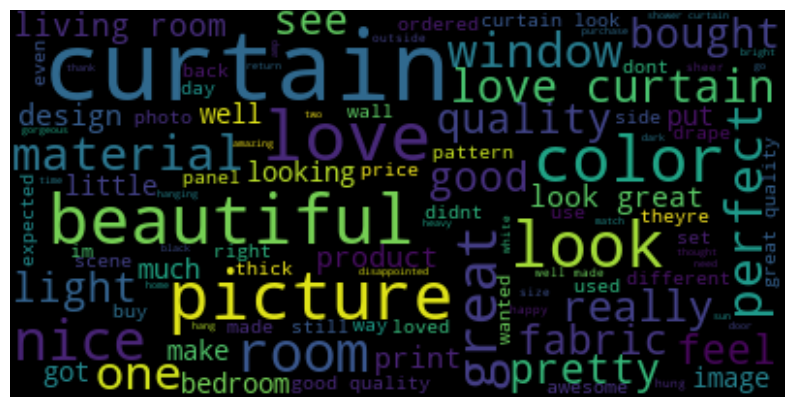

In [104]:
wordcloud = WordCloud(max_font_size=50,
                        max_words=100,
                        background_color="black").generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

---
### Görev 3: Sentiment Analysis


#### Adım 1: Python içerisindeki NLTK paketinde tanımlanmış olan SentimentIntensityAnalyzer nesnesini oluşturunuz.

In [105]:
sia = SentimentIntensityAnalyzer()

#### Adım 2: SentimentIntensityAnalyzer nesnesi ile polarite puanlarını inceleyiniz;

##### "Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesaplayınız.

In [106]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

#### İncelenen ilk 10 gözlem için compund skorlarına göre filtreleyerek tekrar gözlemleyiniz.

In [107]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

#### 10 gözlem için compound skorları 0'dan büyükse "pos" değilse "neg" şeklinde güncelleyiniz.

In [108]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

#### "Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken olarak dataframe'e ekleyiniz.

In [109]:
df["Sentiment_Analysis"] =  df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"]> 0 else "neg")

In [110]:
df.head(2)

,Star,HelpFul,Title,Review,Sentiment_Analysis
0,5,0,looks great,happy,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched,pos


In [111]:
df.groupby("Sentiment_Analysis")["Star"].mean()

Sentiment_Analysis
neg   3.40
pos   4.58
Name: Star, dtype: float64

---
### Görev 4: Makine Öğrenmesine Hazırlık

#### Adım 1: Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olarak ayırınız.

In [114]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["Sentiment_Analysis"],
                                                    random_state=42)

#### Adım 2: Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte;

#### TfidfVectorizer kullanarak bir nesne oluşturunuz.
#### Daha önce ayırmış olduğumuz train datamızı kullanarak oluşturduğumuz nesneye fit ediniz.

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)

#### Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediniz

In [ ]:
## TF-IDF Word Level

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

--- 
### Görev 5: Modelleme (Lojistik Regresyon)

#### Adım 1: Lojistik regresyon modelini kurarak train dataları ile fit ediniz.

In [120]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

#### Adım 2: Kurmuş olduğunuz model ile tahmin işlemleri gerçekleştiriniz.

#### Predict fonksiyonu ile test datasını tahmin ederek kaydediniz.

In [ ]:
y_pred = log_model.predict(x_test_tf_idf_word) #test verisinin vektörize edilmiş halini veriyoruz

#### classification_report ile tahmin sonuçlarınızı raporlayıp gözlemleyiniz.

In [123]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

         neg       0.90      0.32      0.47       224
         pos       0.89      0.99      0.94      1179

    accuracy                           0.89      1403
   macro avg       0.89      0.66      0.70      1403
weighted avg       0.89      0.89      0.86      1403



#### cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız.

In [124]:
cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()

np.float64(0.8538891713268937)

#### Adım 3: Veride bulunan yorumlardan ratgele seçerek modele sorulması;

#### sample fonksiyonu ile "Review" değişkeni içerisinden örneklem seçerek yeni bir değere atayınız.

In [125]:
random_review = pd.Series(df["Review"].sample(1).values)

In [126]:
random_review

0    sooo beautiful happy purchase great quality go...
dtype: object

#### Elde ettiğiniz örneklemi modelin tahmin edebilmesi için CountVectorizer ile vektörleştiriniz
##### Vektörleştirdiğiniz örneklemi fit ve transform işlemlerini yaparak kaydediniz.

In [128]:
from sklearn.feature_extraction.text import CountVectorizer

yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)

#### Kurmuş olduğunuz modele örneklemi vererek tahmin sonucunu kaydediniz.
##### Örneklemi ve tahmin sonucunu ekrana yazdırınız.

In [129]:
pred = log_model.predict(yeni_yorum)

In [130]:
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  sooo beautiful happy purchase great quality got time 
 Prediction: ['pos']


---
### Görev 6: Modelleme (Random Forest)

### Adım 1: Random Forest modeli ile tahmin sonuçlarının gözlenmesi;

- #### RandomForestClassifier modelini kurup fit ediniz.

In [131]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)

- #### Cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız.
- #### Lojistik regresyon modeli ile sonuçları karşılaştırınız.

In [132]:
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

np.float64(0.8873817996949669)

- ### Logistik Regression Cross Val Score : 0.8538891713268937
- ### RandomForestClassifier Cross Val Score : 0.8873817996949669